# 1.Import lib

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler, label_binarize, PolynomialFeatures
from sklearn import preprocessing
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer,KNNImputer
from sklearn.compose import ColumnTransformer

from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import missingno as msno
import torch
import torch.nn as nn
import torch.optim as optim

# 2. Read data

In [2]:
train_ds = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')

test_ds = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')

data_dictionary = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/data_dictionary.csv')



In [3]:
def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df

In [4]:
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

100%|██████████| 2/2 [00:00<00:00, 11.47it/s]


In [5]:
train_ts

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,50458.0,...,5.314874,89.422226,0.0,2626.199951,4187.0,8.639500e+13,7.0,2.0,57.0,0745c390
1,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,340584.0,...,3.966906,89.080330,1.0,2628.199951,4146.0,8.639500e+13,7.0,2.0,243.0,eaab7a96
2,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,40003.0,...,5.066334,86.987267,0.0,2618.199951,4183.0,8.636500e+13,7.0,3.0,134.0,8ec2cc63
3,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,223915.0,...,6.134459,89.976074,0.0,2502.000000,6000.0,8.639500e+13,7.0,4.0,72.0,b2987a65
4,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,15420.0,...,2.774382,89.300034,0.0,1046.800049,4199.0,8.601500e+13,7.0,4.0,76.0,7b8842c3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,394128.0,...,3.669502,89.025551,1.0,2576.399902,4191.0,8.639500e+13,7.0,4.0,161.0,cd68643b
992,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,1195.0,...,1.786410,81.665283,0.0,1526.599976,4194.0,8.514000e+13,7.0,2.0,130.0,f8ff0bc8
993,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,393240.0,...,3.692727,89.333710,1.0,2592.199951,4178.0,8.639500e+13,7.0,1.0,79.0,db23fbe4
994,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,40085.0,...,1.673958,88.629547,0.0,1875.199951,4183.0,8.639500e+13,7.0,1.0,155.0,687c85e7


In [6]:
test_ts

,stat_0,stat_1,stat_2,stat_3,stat_4,stat_5,stat_6,stat_7,stat_8,stat_9,...,stat_87,stat_88,stat_89,stat_90,stat_91,stat_92,stat_93,stat_94,stat_95,id
0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,43330.0,...,4.004276,89.751656,0.0,2633.250000,4188.5,8.611000e+13,7.0,3.0,85.0,00115b9f
1,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,396396.0,...,2.952888,89.476036,1.0,2597.800049,4175.0,8.639500e+13,7.0,3.0,91.0,001f3379


In [7]:
train_ds

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0
3956,ffa9794a,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,NaN
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0
3958,ffed1dd5,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0.0


In [8]:
test_ds

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,...,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,...,27.0552,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,...,NaN,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,...,45.9966,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,Summer,1.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,...,63.1265,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring,0.0
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,...,47.2211,NaN,NaN,Winter,3.670,Winter,27.0,40.0,Fall,3.0
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,...,50.4767,NaN,NaN,Fall,1.270,NaN,NaN,NaN,Fall,2.0
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Summer,2.0
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 82 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      3960 non-null   object 
 1   Basic_Demos-Enroll_Season               3960 non-null   object 
 2   Basic_Demos-Age                         3960 non-null   int64  
 3   Basic_Demos-Sex                         3960 non-null   int64  
 4   CGAS-Season                             2555 non-null   object 
 5   CGAS-CGAS_Score                         2421 non-null   float64
 6   Physical-Season                         3310 non-null   object 
 7   Physical-BMI                            3022 non-null   float64
 8   Physical-Height                         3027 non-null   float64
 9   Physical-Weight                         3076 non-null   float64
 10  Physical-Waist_Circumference            898 non-null    floa

In [10]:
test_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 59 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   id                                      20 non-null     object 
 1   Basic_Demos-Enroll_Season               20 non-null     object 
 2   Basic_Demos-Age                         20 non-null     int64  
 3   Basic_Demos-Sex                         20 non-null     int64  
 4   CGAS-Season                             10 non-null     object 
 5   CGAS-CGAS_Score                         8 non-null      float64
 6   Physical-Season                         14 non-null     object 
 7   Physical-BMI                            13 non-null     float64
 8   Physical-Height                         13 non-null     float64
 9   Physical-Weight                         13 non-null     float64
 10  Physical-Waist_Circumference            5 non-null      float64


In [11]:
# Kiểm tra xem các data trong timeseries có label không
combine = pd.merge(train_ts, train_ds[['id', 'sii']], on='id', how='left')
# Kiểm tra số lượng data không nhãn
combine['sii'].isna().sum() 
# => Tất cả data trong timne series đều có nhãn

0

Change the values on columns with Dtype object to numbers

In [12]:
# Kiểm tra các cột dư thừa ở trong train không có trong test
different_columns = set(train_ds) - set(test_ds)
different_columns # Cột sii là label, cần dữ lại

{'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_03',
 'PCIAT-PCIAT_04',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_10',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_20',
 'PCIAT-PCIAT_Total',
 'PCIAT-Season',
 'sii'}

In [13]:
# train_ds = train_ds.drop(columns='id')

In [14]:
train_cat_columns = train_ds.select_dtypes(exclude = 'number').columns

for season in train_cat_columns:
    train_ds[season] = train_ds[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

/tmp/ipykernel_23/797651415.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_ds[season] = train_ds[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})


In [15]:
test_cat_columns = test_ds.select_dtypes(exclude = 'number').columns

for season in test_cat_columns:
    test_ds[season] = test_ds[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})

/tmp/ipykernel_23/1751643514.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_ds[season] = test_ds[season].replace({'Spring':1, 'Summer':2, 'Fall':3, 'Winter':4})


In [16]:
# Kiểm tra kích thước time series
print(f"2 tập cùng số features: {train_ts.shape[1] == test_ts.shape[1]}") 
# True => Các fetures tồn tại trong cả train và test
print(f"Số features: {train_ts.shape[1]}")

2 tập cùng số features: True
Số features: 97


* **Encode data**

In [17]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim*3),
            nn.ReLU(),
            nn.Linear(encoding_dim*3, encoding_dim*2),
            nn.ReLU(),
            nn.Linear(encoding_dim*2, encoding_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim*2),
            nn.ReLU(),
            nn.Linear(input_dim*2, input_dim*3),
            nn.ReLU(),
            nn.Linear(input_dim*3, input_dim),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [18]:
def perform_autoencoder(df, encoding_dim=50, epochs=50, batch_size=32):
    # Scale lại data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)
    
    data_tensor = torch.FloatTensor(df_scaled)
    
    input_dim = data_tensor.shape[1]
    autoencoder = AutoEncoder(input_dim, encoding_dim)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(autoencoder.parameters())

    # Huấn luyện mô hình Autoencoder
    for epoch in range(epochs):
        for i in range(0, len(data_tensor), batch_size):
            batch = data_tensor[i : i + batch_size]
            optimizer.zero_grad()
            reconstructed = autoencoder(batch)
            loss = criterion(reconstructed, batch)
            loss.backward()
            optimizer.step()
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}]')

    # Encoder dữ liệu - Chỉ lấy phần encoder
    with torch.no_grad():
        encoded_data = autoencoder.encoder(data_tensor).numpy()
        
    df_encoded = pd.DataFrame(encoded_data, columns=[f'Enc_{i + 1}' for i in range(encoded_data.shape[1])])
    
    return df_encoded

In [19]:
df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

print("Train encode")
train_ts_encoded = perform_autoencoder(df_train, encoding_dim=70, epochs=200, batch_size=32)
print("Test encode")
test_ts_encoded = perform_autoencoder(df_test, encoding_dim=70, epochs=200, batch_size=32)

Train encode
Epoch [10/200], Loss: 1.6337]
Epoch [20/200], Loss: 1.5451]
Epoch [30/200], Loss: 1.5164]
Epoch [40/200], Loss: 1.4593]
Epoch [50/200], Loss: 1.3939]
Epoch [60/200], Loss: 1.3689]
Epoch [70/200], Loss: 1.3700]
Epoch [80/200], Loss: 1.3658]
Epoch [90/200], Loss: 1.3661]
Epoch [100/200], Loss: 1.3645]
Epoch [110/200], Loss: 1.3534]
Epoch [120/200], Loss: 1.3529]
Epoch [130/200], Loss: 1.3536]
Epoch [140/200], Loss: 1.3526]
Epoch [150/200], Loss: 1.3506]
Epoch [160/200], Loss: 1.3498]
Epoch [170/200], Loss: 1.3514]
Epoch [180/200], Loss: 1.3511]
Epoch [190/200], Loss: 1.3568]
Epoch [200/200], Loss: 1.3490]
Test encode
Epoch [10/200], Loss: 1.0076]
Epoch [20/200], Loss: 0.5977]
Epoch [30/200], Loss: 0.4271]
Epoch [40/200], Loss: 0.4271]
Epoch [50/200], Loss: 0.4271]
Epoch [60/200], Loss: 0.4271]
Epoch [70/200], Loss: 0.4271]
Epoch [80/200], Loss: 0.4271]
Epoch [90/200], Loss: 0.4271]
Epoch [100/200], Loss: 0.4271]
Epoch [110/200], Loss: 0.4271]
Epoch [120/200], Loss: 0.4271]
E

In [20]:
# Lấy lại id
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

In [21]:
# Hợp nhất dữ liệu dựa trên id

train_ds = pd.merge(train_ds, train_ts_encoded, how="left", on='id')
test_ds = pd.merge(test_ds, test_ts_encoded, how="left", on='id')

In [22]:
train_ds

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,Enc_61,Enc_62,Enc_63,Enc_64,Enc_65,Enc_66,Enc_67,Enc_68,Enc_69,Enc_70
0,00008ff9,3,5,0,4.0,51.0,3.0,16.877316,46.0,50.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,2,9,0,NaN,NaN,3.0,14.035590,48.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00105258,2,10,1,3.0,71.0,3.0,16.648696,56.5,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,4,9,0,3.0,71.0,2.0,18.292347,56.0,81.6,...,0.00000,0.0,4.174508,0.0,0.0,0.000000,3.012166,0.531953,9.499336,0.387703
4,0016bb22,1,18,1,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,3,13,0,1.0,60.0,3.0,16.362460,59.5,82.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3956,ffa9794a,4,10,0,NaN,NaN,1.0,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3957,ffcd4dbd,3,11,0,1.0,68.0,4.0,21.441500,60.0,109.8,...,0.00000,0.0,2.508663,0.0,0.0,0.847157,0.000000,2.883129,0.000000,7.598742
3958,ffed1dd5,1,13,0,1.0,70.0,4.0,12.235895,70.7,87.0,...,2.40179,0.0,8.378176,0.0,0.0,1.435596,0.000000,0.035302,0.000000,0.000000


# 2.1 Selecting the data

now we need to eliminating all the rows that have a null value on the target column 'sii'. Eliminating the columns that aren't on test.csv. Eliminating all the columns that have more than 50% of the remaining rows with null values, and finally, we use the .corr function of pandas, which uses Pearson correlation, to see which of the remaining columns have the most effect on 'PCIAT-PCIAT_Total' from which 'sii' originates from.

**del null row**

In [23]:
null = train_ds.isna().sum().sort_values(ascending = False).head(70)
null = pd.DataFrame(null)
null = null.rename(columns= {0:'Missing'})
null.style.background_gradient(cmap='YlOrRd')

,Missing
PAQ_A-PAQ_A_Total,3485
PAQ_A-Season,3485
Fitness_Endurance-Time_Mins,3220
Fitness_Endurance-Time_Sec,3220
Fitness_Endurance-Max_Stage,3217
Physical-Waist_Circumference,3062
Enc_24,2964
Enc_23,2964
Enc_38,2964
Enc_37,2964


In [24]:
train_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Columns: 152 entries, id to Enc_70
dtypes: float32(70), float64(78), int64(3), object(1)
memory usage: 3.5+ MB


In [25]:
train_ds_usable = train_ds[train_ds['sii'].notnull()]

null = train_ds_usable.isna().sum().sort_values(ascending = False).head(70)
null = pd.DataFrame(null)
null = null.rename(columns= {0:'Missing'})
null.style.background_gradient(cmap='YlOrRd')

,Missing
PAQ_A-PAQ_A_Total,2373
PAQ_A-Season,2373
Physical-Waist_Circumference,2253
Fitness_Endurance-Time_Sec,2008
Fitness_Endurance-Time_Mins,2008
Fitness_Endurance-Max_Stage,2005
FGC-FGC_GSD_Zone,1872
FGC-FGC_GSND_Zone,1872
FGC-FGC_GSD,1865
FGC-FGC_GSND,1864


In [26]:
train_ds_usable.shape

(2736, 152)

In [27]:
train_ds_usable.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Columns: 152 entries, id to Enc_70
dtypes: float32(70), float64(78), int64(3), object(1)
memory usage: 2.5+ MB


**del row not in file test.csv**

In [28]:
PCIAT_cols = [val for val in train_ds_usable.columns[train_ds_usable.columns.str.contains('PCIAT')]]
print('Number of PCIAT features = ' , len(PCIAT_cols))

Number of PCIAT features =  22


In [29]:
PCIAT_cols.remove('PCIAT-PCIAT_Total')
train_ds_usable = train_ds_usable.drop(columns = PCIAT_cols)
train_ds_usable.shape

(2736, 131)

## 2.2 Use Pearson correlation to determine which columns to keep

In [30]:
train_ds_usable = train_ds_usable.drop(columns = 'id')
corr = pd.DataFrame(train_ds_usable.corr()['PCIAT-PCIAT_Total'].sort_values(ascending = False))
corr.style.background_gradient(cmap='YlOrRd')

,PCIAT-PCIAT_Total
PCIAT-PCIAT_Total,1.000000
sii,0.899681
Physical-Height,0.420765
Basic_Demos-Age,0.409559
PreInt_EduHx-computerinternet_hoursday,0.374124
Physical-Weight,0.353048
Physical-Waist_Circumference,0.327013
FGC-FGC_CU,0.287494
BIA-BIA_BMI,0.248060
Physical-BMI,0.240858


In [31]:
selection = corr[(corr['PCIAT-PCIAT_Total']>.05) | (corr['PCIAT-PCIAT_Total']<-.05) | (corr['PCIAT-PCIAT_Total'].isna())]
selection = [val for val in selection.index]
selection.remove('PCIAT-PCIAT_Total')
selection.remove('sii')
selection.remove('Physical-BMI')
selection.remove('SDS-SDS_Total_Raw')
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'SDS-SDS_Total_T',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'FGC-FGC_GSD',
 'Enc_27',
 'Physical-Systolic_BP',
 'FGC-FGC_GSND',
 'Enc_55',
 'FGC-FGC_TL',
 'Enc_40',
 'Enc_46',
 'Enc_3',
 'Enc_44',
 'BIA-BIA_FFMI',
 'Enc_60',
 'Enc_11',
 'Enc_34',
 'Enc_68',
 'Enc_61',
 'BIA-BIA_FMI',
 'BIA-BIA_Activity_Level_num',
 'Enc_67',
 'Enc_6',
 'Enc_59',
 'Enc_50',
 'Enc_4',
 'BIA-BIA_LST',
 'PAQ_A-Season',
 'Fitness_Endurance-Season',
 'Enc_25',
 'Physical-Diastolic_BP',
 'Enc_70',
 'Enc_7',
 'Enc_32',
 'Enc_57',
 'FGC-FGC_PU_Zone',
 'Enc_12',
 'Enc_18',
 'Enc_63',
 'BIA-BIA_DEE',
 'BIA-BIA_SMM',
 'BIA-BIA_ICW',
 'Enc_54',
 'Fitness_Endurance-Time_Mins',
 'Enc_41',
 'Enc_51',
 'Enc_21',
 'Enc_28',
 'CGAS-CGAS_Score',
 'Enc_5',
 'Enc_22',
 'FGC-FGC_SRR',
 'Enc_14',
 'Enc_45',
 'Enc_33',
 'FGC-FGC_SRL',
 'Basic_Demos-Sex',
 'Enc_43',

> after filter we now have 15 col left for train model

> Delete col with more than 50% data is null

In [32]:
half_missing = [val for val in train_ds_usable.columns[train_ds_usable.isnull().sum()>len(train_ds_usable)*0.7]]
half_missing

['Physical-Waist_Circumference',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec',
 'PAQ_A-Season',
 'PAQ_A-PAQ_A_Total']

In [33]:
selection = [i for i in selection if i not in half_missing]
selection

['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'SDS-SDS_Total_T',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'FGC-FGC_GSD',
 'Enc_27',
 'Physical-Systolic_BP',
 'FGC-FGC_GSND',
 'Enc_55',
 'FGC-FGC_TL',
 'Enc_40',
 'Enc_46',
 'Enc_3',
 'Enc_44',
 'BIA-BIA_FFMI',
 'Enc_60',
 'Enc_11',
 'Enc_34',
 'Enc_68',
 'Enc_61',
 'BIA-BIA_FMI',
 'BIA-BIA_Activity_Level_num',
 'Enc_67',
 'Enc_6',
 'Enc_59',
 'Enc_50',
 'Enc_4',
 'BIA-BIA_LST',
 'Fitness_Endurance-Season',
 'Enc_25',
 'Physical-Diastolic_BP',
 'Enc_70',
 'Enc_7',
 'Enc_32',
 'Enc_57',
 'FGC-FGC_PU_Zone',
 'Enc_12',
 'Enc_18',
 'Enc_63',
 'BIA-BIA_DEE',
 'BIA-BIA_SMM',
 'BIA-BIA_ICW',
 'Enc_54',
 'Enc_41',
 'Enc_51',
 'Enc_21',
 'Enc_28',
 'CGAS-CGAS_Score',
 'Enc_5',
 'Enc_22',
 'FGC-FGC_SRR',
 'Enc_14',
 'Enc_45',
 'Enc_33',
 'FGC-FGC_SRL',
 'Basic_Demos-Sex',
 'Enc_43',
 'Enc_9',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone',
 'Enc_13',
 'Enc_15',
 'Enc_1

In [34]:

train_ds_selection = train_ds_usable[selection]

In [35]:
train_ds_selection.describe()

,Physical-Height,Basic_Demos-Age,PreInt_EduHx-computerinternet_hoursday,Physical-Weight,FGC-FGC_CU,BIA-BIA_BMI,SDS-SDS_Total_T,FGC-FGC_PU,BIA-BIA_Frame_num,FGC-FGC_GSD,...,Enc_19,Enc_24,Enc_29,Enc_35,Enc_39,Enc_48,Enc_58,Enc_62,Enc_64,Enc_65
count,2530.000000,2736.000000,2654.000000,2572.000000,1919.000000,1813.000000,2525.000000,1909.000000,1813.000000,871.000000,...,996.0,996.0,996.0,996.0,996.0,996.0,996.0,996.0,996.0,996.0
mean,55.897051,10.238670,1.015072,87.839592,11.912976,19.232347,57.647525,5.782609,1.733591,23.083639,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,7.394938,3.427982,1.080861,43.353079,11.979877,4.921900,13.042815,7.441061,0.671201,10.517376,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,36.000000,5.000000,0.000000,0.000000,0.000000,0.048267,38.000000,0.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,50.050000,8.000000,0.000000,57.200000,4.000000,15.857600,47.000000,0.000000,1.000000,16.100000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,55.000000,10.000000,1.000000,75.800000,10.000000,17.850600,55.000000,3.000000,2.000000,20.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,61.750000,12.000000,2.000000,111.450000,16.000000,21.206000,64.000000,9.000000,2.000000,27.900000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,78.500000,22.000000,3.000000,315.000000,115.000000,48.375400,100.000000,51.000000,3.000000,123.800000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:

train_ds_selection

,Physical-Height,Basic_Demos-Age,PreInt_EduHx-computerinternet_hoursday,Physical-Weight,FGC-FGC_CU,BIA-BIA_BMI,SDS-SDS_Total_T,FGC-FGC_PU,BIA-BIA_Frame_num,FGC-FGC_GSD,...,Enc_19,Enc_24,Enc_29,Enc_35,Enc_39,Enc_48,Enc_58,Enc_62,Enc_64,Enc_65
0,46.0,5,3.0,50.8,0.0,16.8792,NaN,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.0,9,0.0,46.0,3.0,14.0371,64.0,5.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,56.5,10,2.0,75.6,20.0,NaN,54.0,7.0,NaN,14.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56.0,9,0.0,81.6,18.0,18.2943,45.0,5.0,2.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,59.5,13,0.0,112.2,12.0,30.1865,56.0,6.0,2.0,17.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,52.5,8,2.0,67.2,0.0,17.1417,58.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3954,48.5,7,0.0,46.6,0.0,13.6457,67.0,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3955,59.5,13,1.0,82.4,16.0,16.3642,50.0,10.0,1.0,19.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3957,60.0,11,0.0,109.8,15.0,21.4438,77.0,0.0,2.0,15.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Divide data for training and testing the model

In [37]:
X = train_ds_selection
y = train_ds_usable['sii']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Pipeline processing
preprocess the data before being used on the model, for the categorical columns remaining the null values are filled by the mode, and for the numerical columns the null values are filled by the mean, and are then used by a standard scaler.

In [38]:
categorical_features = ['BIA-BIA_Frame_num', 'FGC-FGC_SRR_Zone', 'FGC-FGC_SRL_Zone']
numeric_features = [col for col in X.columns if col not in categorical_features]

## Initial model

In [39]:
# Pipeline for numerical columns (using mean)
numeric_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  
])

# Pipeline for categorial columns (using mode)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  
])

# Combine both on ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
lgbm_model = LGBMClassifier(random_state=42)
catboost_model = CatBoostClassifier(verbose=0, random_state=42)


# Combine models using VotingClassifier
voting_model = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model)
    ],
    voting='soft'
)

# **Hyperparameter Tuning**
Using GridSearchCV to get the best hyperparameters and using those with the RandomForestClassifier model. The RandomForestClassifier is a good model choice for handling non-linear releationships, reduces overfitting and works well when you have many features.

In [40]:
#Modeling with Random Forests and Hyperparameter Search

param_grid = {
    # Random Forest
    'classifier__rf__n_estimators': [100],  # Cố định giá trị tốt
    'classifier__rf__max_depth': [10],  # Giữ giá trị phổ biến
    'classifier__rf__min_samples_split': [2],  # Cố định giá trị chuẩn
    'classifier__rf__min_samples_leaf': [1],  # Giữ giá trị chuẩn
    
    # XGBClassifier
    'classifier__xgb__n_estimators': [100, 200],  # Tập trung vào số lượng cây trung bình
    'classifier__xgb__max_depth': [6],  # Cố định độ sâu phù hợp
    'classifier__xgb__learning_rate': [0.1],  # Chọn learning rate tối ưu thường gặp
    'classifier__xgb__subsample': [0.8],  # Giữ giá trị ổn định

    # LGBMClassifier
    'classifier__lgbm__n_estimators': [100],  # Số lượng cây cố định
    'classifier__lgbm__max_depth': [-1],  # Không giới hạn độ sâu
    'classifier__lgbm__learning_rate': [0.1],  # Chọn learning rate mặc định
    'classifier__lgbm__num_leaves': [31],  # Số lá nhỏ hơn để tránh overfitting

    # CatBoostClassifier
    'classifier__catboost__iterations': [100],  # Giảm số vòng lặp
    'classifier__catboost__depth': [6],  # Giữ độ sâu thấp
    'classifier__catboost__learning_rate': [0.1]  # Chọn learning rate phổ biến
}



model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', voting_model)
])
model_pipeline.fit(X_train, y_train)
grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_

## Confusion matrix

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10442
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 65
[LightGBM] [Info] Start training from score -0.540042
[LightGBM] [Info] Start training from score -1.320842
[LightGBM] [Info] Start training from score -1.980316
[LightGBM] [Info] Start training from score -4.394906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10442
[LightGBM] [Info] Number of data points in the train set: 2188, number of used features: 65
[Li

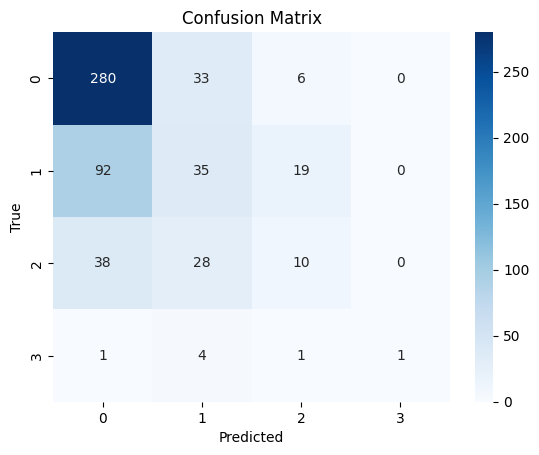

In [41]:
y_pred_final = best_model.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred_final)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# submition


In [42]:
test = test_ds[selection]
test

,Physical-Height,Basic_Demos-Age,PreInt_EduHx-computerinternet_hoursday,Physical-Weight,FGC-FGC_CU,BIA-BIA_BMI,SDS-SDS_Total_T,FGC-FGC_PU,BIA-BIA_Frame_num,FGC-FGC_GSD,...,Enc_19,Enc_24,Enc_29,Enc_35,Enc_39,Enc_48,Enc_58,Enc_62,Enc_64,Enc_65
0,46.00,5,3.0,50.8,0.0,16.8792,NaN,0.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,48.00,9,0.0,46.0,3.0,14.0371,64.0,5.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,56.50,10,2.0,75.6,20.0,NaN,54.0,7.0,NaN,14.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,56.00,9,0.0,81.6,18.0,18.2943,45.0,5.0,2.0,NaN,...,0.0,8.67752,0.000000,6.083782,0.000000,0.0,0.0,0.0,0.0,11.46319
4,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,59.50,13,0.0,112.2,12.0,30.1865,56.0,6.0,2.0,17.9,...,0.0,0.00000,6.635174,4.451467,2.330206,0.0,0.0,0.0,0.0,0.00000
6,55.00,10,3.0,84.6,9.0,19.6629,40.0,2.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,59.25,10,2.0,84.2,0.0,16.8631,NaN,0.0,2.0,11.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,15,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
y_test_pred = best_model.predict(test)
df_submit = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")

x_sub = df_submit[["id"]].copy()
x_sub["sii"] = y_test_pred.astype(int)

In [44]:
x_sub.to_csv('submission.csv', index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
